In [1]:
# Parameters
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"
RULES_OUTPUT_PATH = "data/processed/rules_fpgrowth_filtered.csv"
MIN_SUPPORT = 0.01
MAX_LEN = 3
METRIC = "lift"
MIN_THRESHOLD = 1.0
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1
TOP_N_RULES = 20
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True
PLOT_PLOTLY_SCATTER = True


# Bước 4: FP-Growth Modeling for Association Rules

Notebook này sử dụng ma trận `basket_bool` (được chuẩn bị ở Bước 02) để:

- Khai thác tập mục phổ biến (frequent itemsets) bằng thuật toán FP-Growth
- Sinh luật kết hợp (association rules) với các chỉ số: `support`, `confidence`, `lift`
- Lọc luật theo các ngưỡng do người dùng cấu hình
- Trực quan hoá một số nhóm luật tiêu biểu phục vụ storytelling & phân tích kinh doanh
- So sánh sơ bộ thời gian chạy và số lượng luật thu được so với Apriori (sẽ chi tiết hơn ở Bước 5)

Notebook được thiết kế theo kiểu parameterized để dễ dàng tích hợp với papermill.


In [2]:
# PARAMETERS (for papermill)

# Đường dẫn tới basket_bool được tạo từ Notebook 02
BASKET_BOOL_PATH = "data/processed/basket_bool.parquet"

# Đường dẫn lưu file luật kết hợp sau khi lọc (FP-Growth)
RULES_OUTPUT_PATH = "data/processed/rules_fpgrowth_filtered.csv"

# Tham số cho bước khai thác tập mục phổ biến (frequent itemsets)
MIN_SUPPORT = 0.01  # ngưỡng support tối thiểu
MAX_LEN = 3         # độ dài tối đa của itemset (số sản phẩm trong 1 tập)

# Tham số cho bước sinh luật
METRIC = "lift"     # chỉ số dùng để generate rules: 'support' / 'confidence' / 'lift'
MIN_THRESHOLD = 1.0 # ngưỡng tối thiểu cho METRIC

# Tham số lọc luật sau khi generate
FILTER_MIN_SUPPORT = 0.01
FILTER_MIN_CONF = 0.3
FILTER_MIN_LIFT = 1.2
FILTER_MAX_ANTECEDENTS = 2
FILTER_MAX_CONSEQUENTS = 1

# Số lượng luật top để vẽ biểu đồ
TOP_N_RULES = 20

# Bật/tắt các biểu đồ matplotlib
PLOT_TOP_LIFT = True
PLOT_TOP_CONF = True
PLOT_SCATTER = True
PLOT_NETWORK = True

# Bật/tắt biểu đồ HTML tương tác (Plotly)
PLOT_PLOTLY_SCATTER = True


## Set up

In [3]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# Biểu đồ tương tác HTML
import plotly.express as px

# Determine correct project root
cwd = os.getcwd()
if os.path.basename(cwd) == "notebooks":
    project_root = os.path.abspath("..")
else:
    project_root = cwd

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from cluster_library import FPGrowthMiner, DataVisualizer  


## Thiết lập style vẽ biểu đồ


In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

visualizer = DataVisualizer()


## Tải basket_bool


In [5]:
basket_bool = pd.read_parquet(BASKET_BOOL_PATH)

print("=== Thông tin basket_bool ===")
print(f"- Số hoá đơn (rows): {basket_bool.shape[0]:,}")
print(f"- Số sản phẩm (columns): {basket_bool.shape[1]:,}")
print(f"- Tỷ lệ ô = 1 (có mua): {basket_bool.values.mean():.4f}")

basket_bool.head()


=== Thông tin basket_bool ===
- Số hoá đơn (rows): 16,646
- Số sản phẩm (columns): 3,844
- Tỷ lệ ô = 1 (có mua): 0.0054


,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Khai thác tập phổ biến bằng thuật toán FP-Growth


In [6]:
# Khởi tạo FP-Growth miner
fp_miner = FPGrowthMiner(basket_bool=basket_bool)

start_time = time.time()
frequent_itemsets_fp = fp_miner.mine_frequent_itemsets(
    min_support=MIN_SUPPORT,
    max_len=MAX_LEN,
    use_colnames=True,
)
elapsed_time = time.time() - start_time

print("=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===")
print(f"- Thời gian chạy: {elapsed_time:.2f} giây")
print(f"- Số tập mục phổ biến thu được: {len(frequent_itemsets_fp):,}")

frequent_itemsets_fp.head(10)


=== Kết quả khai thác tập mục phổ biến (FP-Growth) ===
- Thời gian chạy: 3.28 giây
- Số tập mục phổ biến thu được: 968


,support,itemsets
0,0.113180,(WHITE HANGING HEART T-LIGHT HOLDER)
77,0.086928,(JUMBO BAG RED RETROSPOT)
244,0.084705,(REGENCY CAKESTAND 3 TIER)
7,0.078097,(ASSORTED COLOUR BIRD ORNAMENT)
438,0.077496,(PARTY BUNTING)
27,0.067283,(LUNCH BAG RED RETROSPOT)
466,0.060495,(SET OF 3 CAKE TINS PANTRY DESIGN )
141,0.059834,(LUNCH BAG BLACK SKULL.)
18,0.056770,(PAPER CHAIN KIT 50'S CHRISTMAS )
64,0.056350,(NATURAL SLATE HEART CHALKBOARD )


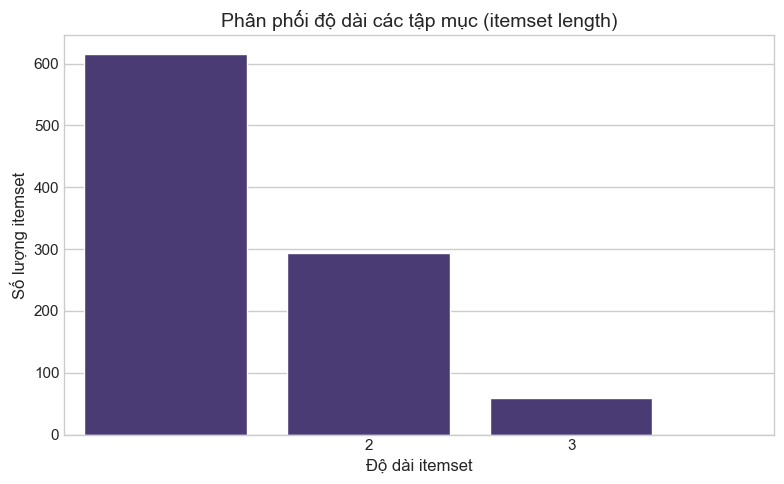

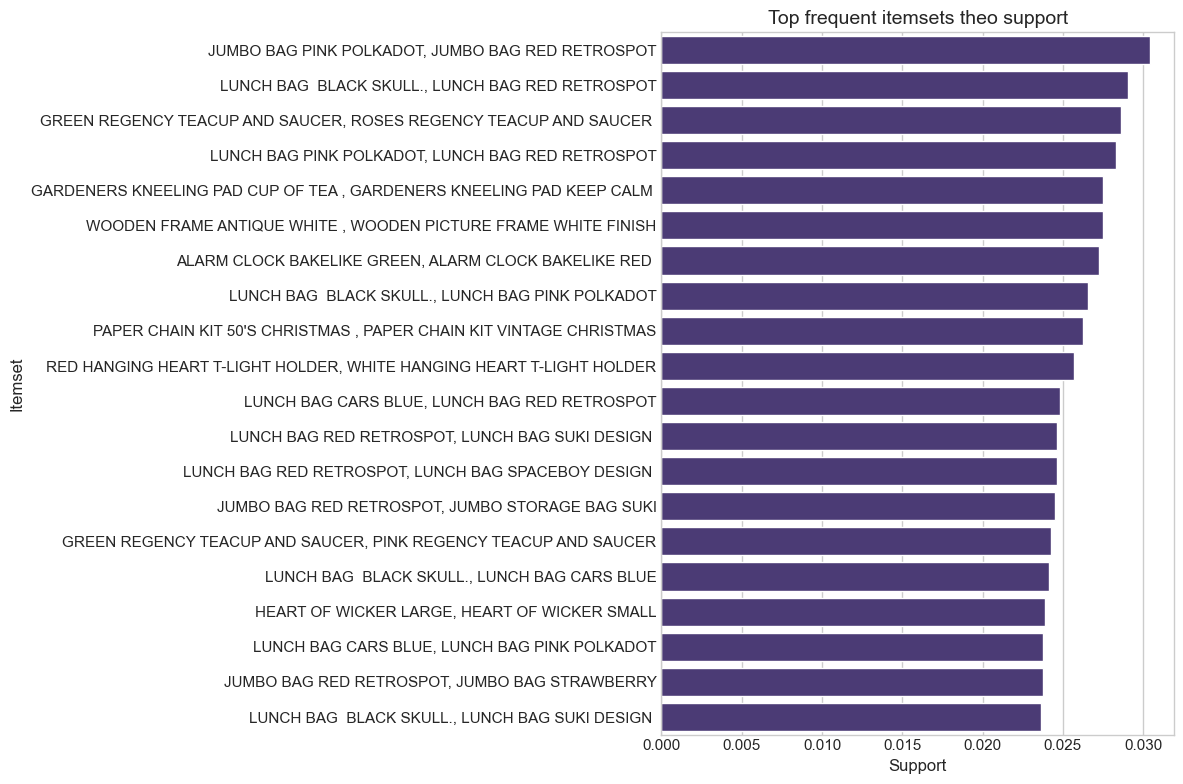

In [7]:
if frequent_itemsets_fp is not None and not frequent_itemsets_fp.empty:
    # Phân phối độ dài các tập mục (1-itemset, 2-itemset, 3-itemset, ...)
    visualizer.plot_itemset_length_distribution(
        frequent_itemsets=frequent_itemsets_fp
    )

    # Top các tập mục phổ biến nhất theo support (ưu tiên itemset có từ 2 sản phẩm trở lên)
    visualizer.plot_top_frequent_itemsets(
        frequent_itemsets=frequent_itemsets_fp,
        top_n=20,
        min_len=2,
    )
else:
    print("Không có frequent itemsets để trực quan hoá.")


## Sinh luật kết hợp từ tập mục phổ biến (FP-Growth)


In [8]:
rules_fp = fp_miner.generate_rules(
    metric=METRIC,
    min_threshold=MIN_THRESHOLD,
)

# Thêm cột dạng chuỗi dễ đọc
rules_fp = fp_miner.add_readable_rule_str()

print("=== Một vài luật kết hợp đầu tiên (FP-Growth, chưa lọc) ===")
cols_preview = [
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift",
]
rules_fp[cols_preview].head(10)


=== Một vài luật kết hợp đầu tiên (FP-Growth, chưa lọc) ===


,antecedents_str,consequents_str,support,confidence,lift
894,HERB MARKER THYME,HERB MARKER ROSEMARY,0.010153,0.944134,86.829038
895,HERB MARKER ROSEMARY,HERB MARKER THYME,0.010153,0.933702,86.829038
586,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,0.011534,0.845815,52.930211
587,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,0.011534,0.721805,52.930211
897,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.010153,0.808612,51.769856
896,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM,0.010153,0.650000,51.769856
828,SET OF 3 WOODEN STOCKING DECORATION,SET OF 3 WOODEN TREE DECORATIONS,0.010333,0.690763,50.211536
829,SET OF 3 WOODEN TREE DECORATIONS,SET OF 3 WOODEN STOCKING DECORATION,0.010333,0.751092,50.211536
767,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.010693,0.851675,49.225611
766,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE LIVINGROOM,0.010693,0.618056,49.225611


## Lọc các luật FP-Growth theo ngưỡng support / confidence / lift


In [9]:
rules_filtered_fp = fp_miner.filter_rules(
    min_support=FILTER_MIN_SUPPORT,
    min_confidence=FILTER_MIN_CONF,
    min_lift=FILTER_MIN_LIFT,
    max_len_antecedents=FILTER_MAX_ANTECEDENTS,
    max_len_consequents=FILTER_MAX_CONSEQUENTS,
)

print("=== Thống kê sau khi lọc luật (FP-Growth) ===")
print(f"- Tổng số luật ban đầu: {rules_fp.shape[0]:,}")
print(f"- Số luật sau khi lọc: {rules_filtered_fp.shape[0]:,}")

rules_filtered_fp[cols_preview].head(10)


=== Thống kê sau khi lọc luật (FP-Growth) ===
- Tổng số luật ban đầu: 942
- Số luật sau khi lọc: 568


,antecedents_str,consequents_str,support,confidence,lift
0,HERB MARKER THYME,HERB MARKER ROSEMARY,0.010153,0.944134,86.829038
1,HERB MARKER ROSEMARY,HERB MARKER THYME,0.010153,0.933702,86.829038
2,REGENCY TEA PLATE GREEN,REGENCY TEA PLATE ROSES,0.011534,0.845815,52.930211
3,REGENCY TEA PLATE ROSES,REGENCY TEA PLATE GREEN,0.011534,0.721805,52.930211
4,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.010153,0.808612,51.769856
5,POPPY'S PLAYHOUSE BEDROOM,POPPY'S PLAYHOUSE LIVINGROOM,0.010153,0.650000,51.769856
6,SET OF 3 WOODEN STOCKING DECORATION,SET OF 3 WOODEN TREE DECORATIONS,0.010333,0.690763,50.211536
7,SET OF 3 WOODEN TREE DECORATIONS,SET OF 3 WOODEN STOCKING DECORATION,0.010333,0.751092,50.211536
8,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE KITCHEN,0.010693,0.851675,49.225611
9,POPPY'S PLAYHOUSE KITCHEN,POPPY'S PLAYHOUSE LIVINGROOM,0.010693,0.618056,49.225611


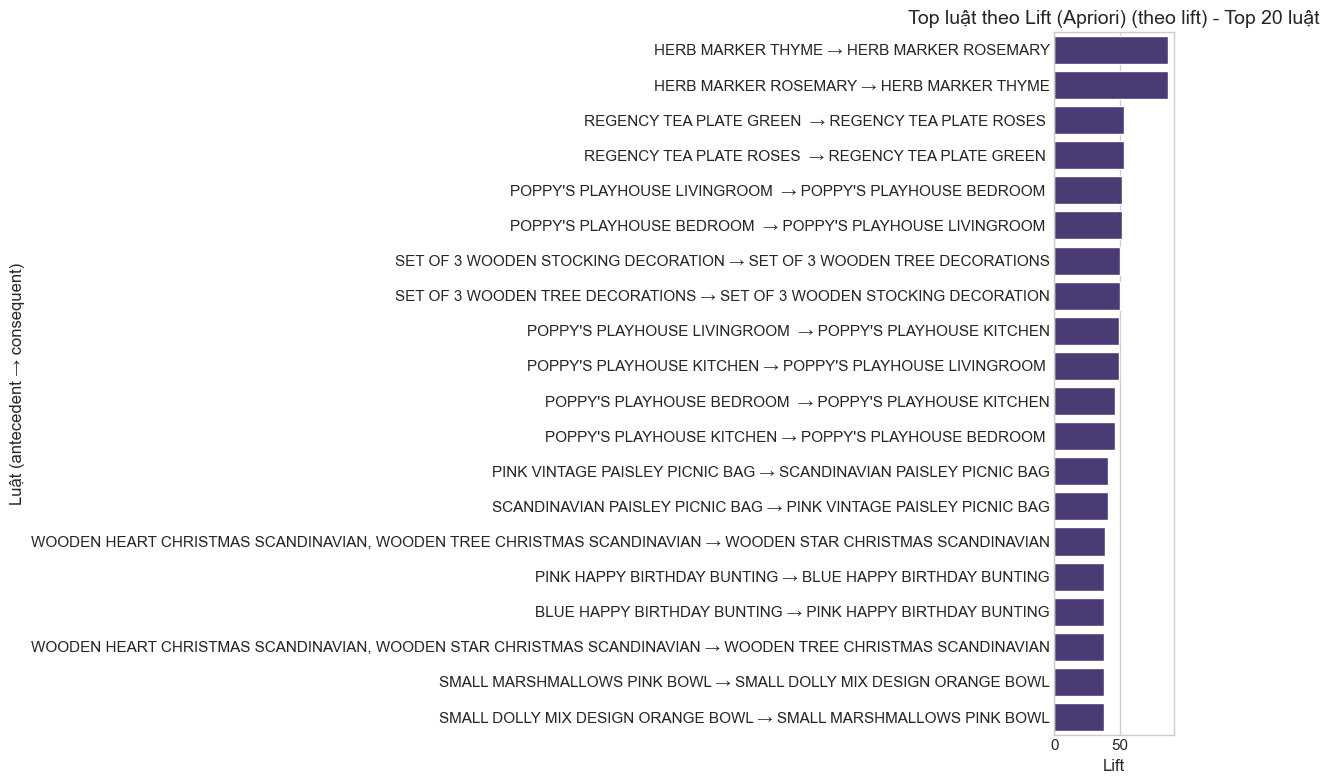

In [10]:
# Cell 16: Top theo lift
if PLOT_TOP_LIFT and not rules_filtered_fp.empty:
    visualizer.plot_top_rules_lift(
        rules_df=rules_filtered_fp,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ top lift.")
    else:
        print("PLOT_TOP_LIFT = False, bỏ qua biểu đồ top lift.")


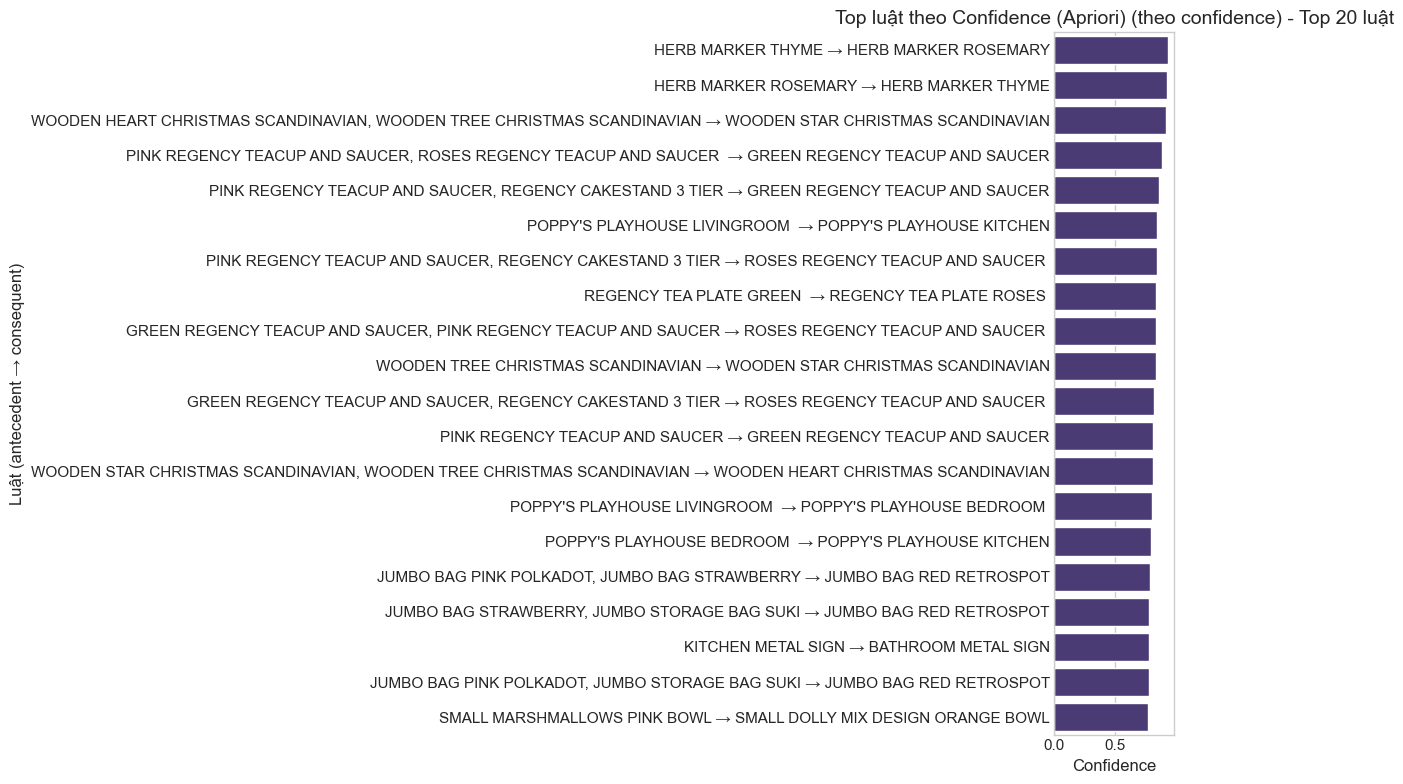

In [11]:
# Cell 17: Top theo confidence
if PLOT_TOP_CONF and not rules_filtered_fp.empty:
    visualizer.plot_top_rules_confidence(
        rules_df=rules_filtered_fp,
        top_n=TOP_N_RULES,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ top confidence.")
    else:
        print("PLOT_TOP_CONF = False, bỏ qua biểu đồ top confidence.")


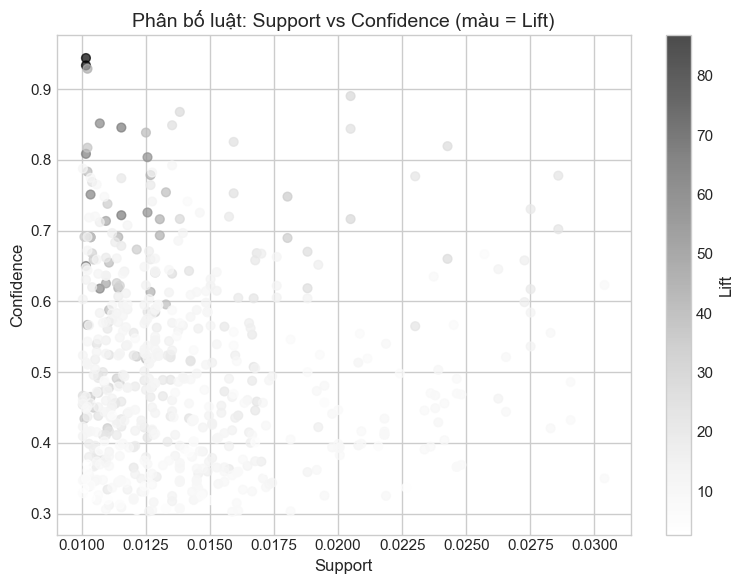

In [12]:
# Cell 18: Scatter support–confidence
if PLOT_SCATTER and not rules_filtered_fp.empty:
    visualizer.plot_rules_support_confidence_scatter(
        rules_df=rules_filtered_fp,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter.")
    else:
        print("PLOT_SCATTER = False, bỏ qua biểu đồ scatter.")


In [13]:
# Cell 19: Scatter Plotly
if PLOT_PLOTLY_SCATTER and not rules_filtered_fp.empty:
    visualizer.plot_rules_support_confidence_scatter_interactive(
        rules_df=rules_filtered_fp,
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ scatter Plotly.")
    else:
        print("PLOT_PLOTLY_SCATTER = False, bỏ qua biểu đồ Plotly.")


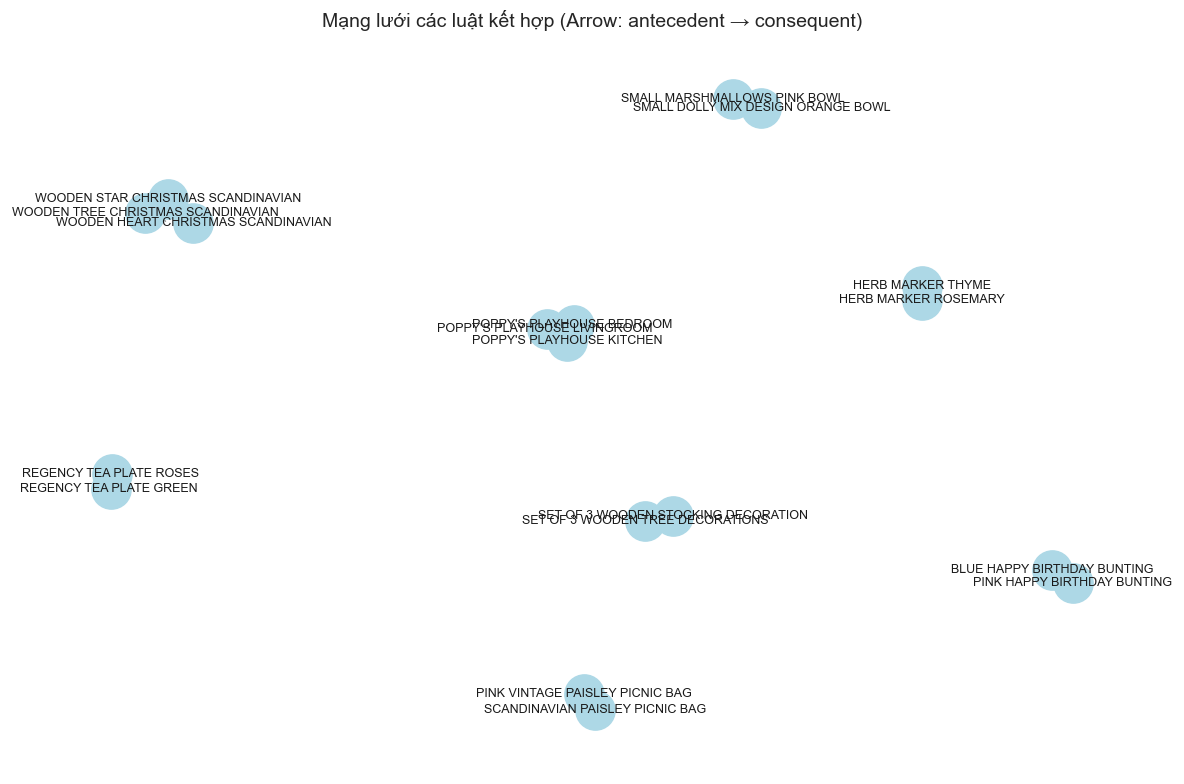

In [14]:
# Cell 20: Network graph
if PLOT_NETWORK and not rules_filtered_fp.empty:
    visualizer.plot_rules_network(
        rules_df=rules_filtered_fp,
        max_rules=min(TOP_N_RULES, 30),
    )
else:
    if rules_filtered_fp.empty:
        print("Không có luật nào sau khi lọc để vẽ network graph.")
    else:
        print("PLOT_NETWORK = False, bỏ qua network graph.")


In [15]:
fp_miner.save_rules(
    output_path=RULES_OUTPUT_PATH,
    rules_df=rules_filtered_fp,
)

print("Đã lưu luật FP-Growth đã lọc:")
print(f"- File: {RULES_OUTPUT_PATH}")
print(f"- Số luật: {rules_filtered_fp.shape[0]:,}")


Đã lưu luật vào: data/processed/rules_fpgrowth_filtered.csv
Đã lưu luật FP-Growth đã lọc:
- File: data/processed/rules_fpgrowth_filtered.csv
- Số luật: 568
